<h1 align="center"><font size="5">Medical Cost Analysis</font></h1>

This is a guided project aiming to estimate the approximate cost of health insurance of individuals based on the given personal information. The dataset can be found [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download&select=insurance.csv).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Importing the Data and Summary Statistics

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
print("Shape of the data frame:", df.shape)
print("Number of missing values for each column:")
df.isna().sum()

Shape of the data frame: (1337, 7)
Number of missing values for each column:


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
print("Descriptive stats for numeric columns:")
df.describe().T

Descriptive stats for numeric columns:


,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


One important thing revealed from that stats table is the huge difference between mean and median of charges (also it has a very high standard deviation).

In [8]:
print("Descriptive stats for non-numeric columns:")
df.describe(include=['O']).T

Descriptive stats for non-numeric columns:


,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


Non-smokers make up almost **four fifths** of the total, whereas others has a well-balanced distribution.

# Visualization

In [9]:
plt.rcParams["figure.figsize"] = (10,6)

##### Examine the distribution of body mass index.

Text(0.5, 1.0, 'Histogram of Body Mass Index (BMI)')

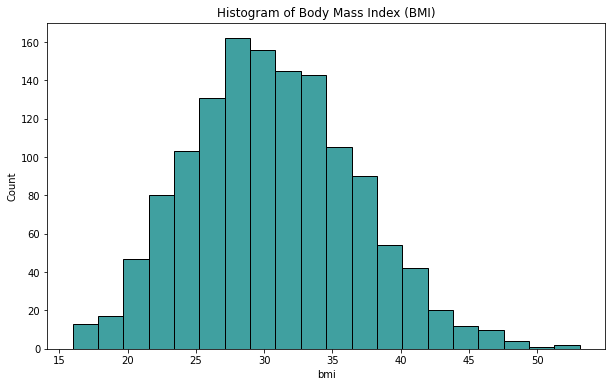

In [10]:
sns.histplot(df["bmi"],bins = 20, color = "teal")
plt.title("Histogram of Body Mass Index (BMI)")

The distribution of BMI looks normal but it is right-skewed. The Right tail is fatter which means more extreme values are observed compared to the left tail.

##### Examine the relationship between "smoker" and "charges".

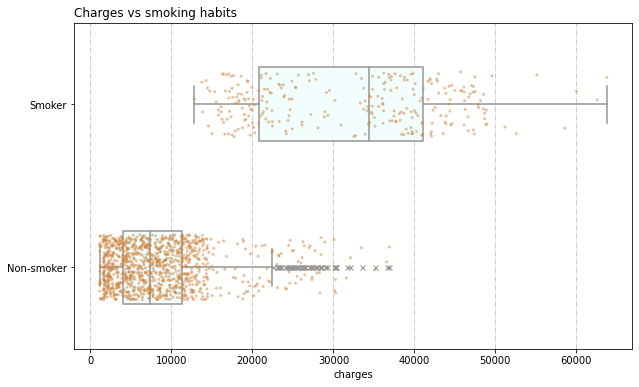

In [11]:
ax = sns.boxplot(x="charges", y="smoker", data=df, color="azure", flierprops={"marker": "x"}, width=.45)
ax = sns.stripplot(x="charges", y="smoker", data=df, color="peru", jitter=0.2, size=3, alpha = .5)
plt.title("Charges vs smoking habits", loc="left")
ax.set_yticklabels(["Smoker","Non-smoker"])
ax.set_ylabel("")
ax.set_axisbelow(True)
ax.grid(axis = "x", color = "gray", alpha = .5, linestyle = "dashdot")

There's a huge difference in charges among smokers and non-smokers. Median of smokers is 5 time as median of non-smokers.

##### Examine the relationship between "smoker" and "region".

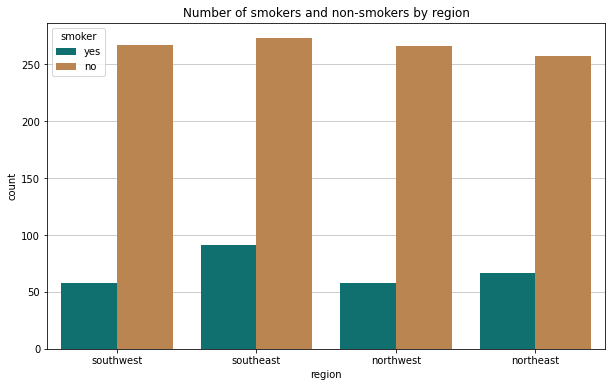

In [12]:
ax = sns.countplot(data=df, x="region", hue="smoker", palette=["teal", "peru"])
plt.title("Number of smokers and non-smokers by region")
ax.set_axisbelow(True)
ax.grid(axis = "y", color = "gray", alpha = .5)

##### Examine the relationship between "bmi" and "sex".

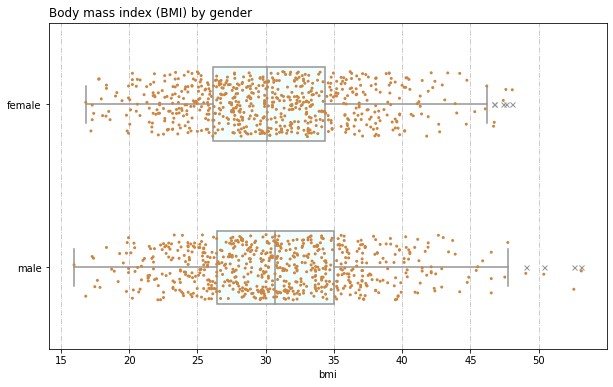

In [13]:
ax = sns.boxplot(x="bmi", y="sex", data=df, color="azure", flierprops={"marker": "x"}, width=.45)
ax = sns.stripplot(x="bmi", y="sex", data=df, color="peru", jitter=0.2, size=3)
plt.title("Body mass index (BMI) by gender", loc="left")
ax.set_ylabel("")
ax.set_axisbelow(True)
ax.grid(axis = "x", color = "gray", alpha = .5, linestyle = "dashdot")

There is no significant difference.

##### Find the "region" with the most "children".

In [14]:
children_by_region = df.groupby("region")["children"].sum().sort_values(ascending=False).to_frame()
children_by_region

,children
region,
southeast,382
northwest,373
southwest,371
northeast,339


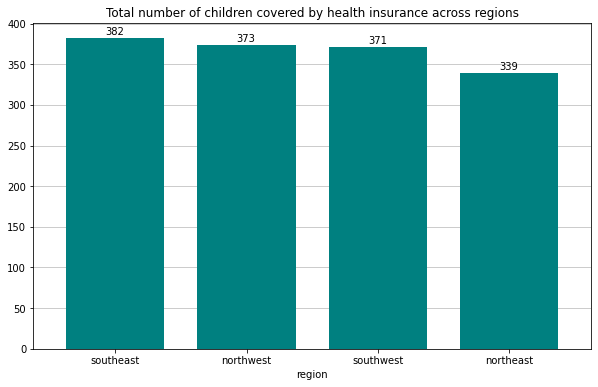

In [15]:
ax = children_by_region.plot(kind="bar", rot = 0, legend = None, color = "teal", width = .75)
ax.set_axisbelow(True)
ax.grid(axis = "y", color = "gray", alpha = .5)
ax.set_title("Total number of children covered by health insurance across regions")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+.3, p.get_height() + 5))

##### Examine the relationship between "age" and "bmi".

In [16]:
age_bmi = stats.pearsonr(df["age"],df["bmi"])
age_bmi_text = f"corr. coef: {round(age_bmi[0],2)} \np-value: {round(age_bmi[1],4)}"

Text(59, 52, 'corr. coef: 0.11 \np-value: 0.0001')

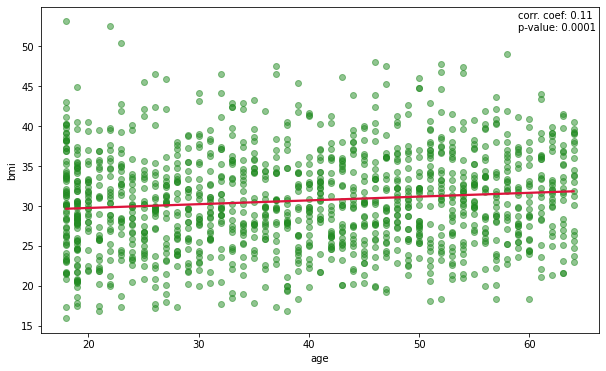

In [17]:
sns.regplot(x="age", y="bmi", data=df, ci=None, color="forestgreen", scatter_kws={'alpha':.5}, line_kws={"color":"crimson"})
plt.annotate(age_bmi_text, (59,52))

There's a too weak linear relationship between age and body mass index.

##### Examine the relationship between "bmi" and "children".

In [18]:
bmi_child = stats.pearsonr(df["bmi"],df["children"])
bmi_child_text = f"corr. coef: {round(bmi_child[0],2)} \np-value: {round(bmi_child[1],2)}"

Text(4.6, 52, 'corr. coef: 0.01 \np-value: 0.64')

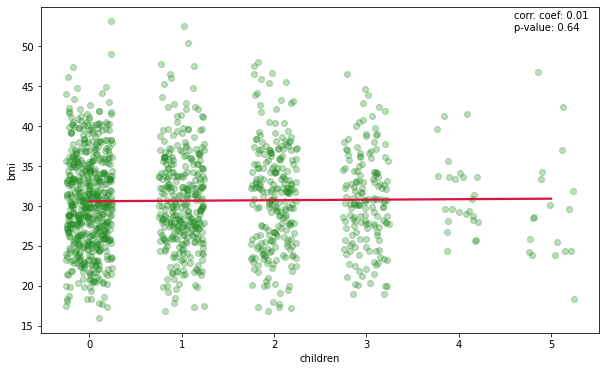

In [19]:
sns.regplot(x="children", y="bmi", data=df, x_jitter=.25, ci=None, color="forestgreen", scatter_kws={'alpha':.3},
            line_kws={"color":"crimson"})
plt.annotate(bmi_child_text, (4.6,52))

No linear relationship is observed.

##### Outliers in BMI

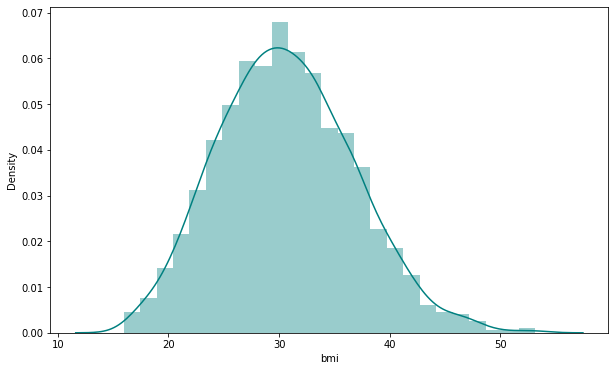

In [20]:
sns.distplot(df["bmi"], color = "teal")

Distribution is quite similar to normal (just slightly right skewed) but that doesn't mean that BMI have no outliers. We might want to see the box plot of BMI and imply some statistical tests.

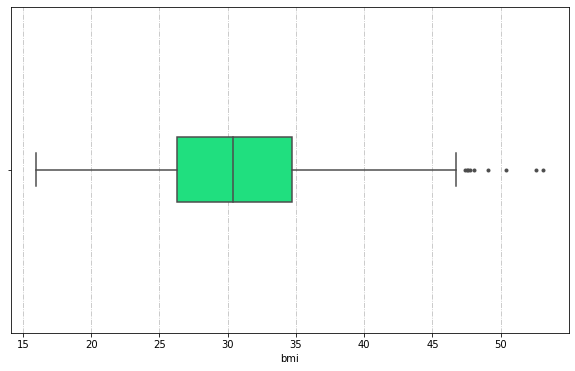

In [21]:
ax = sns.boxplot(x=df["bmi"], fliersize = 3, flierprops={"marker": "o"}, width = .2, color="springgreen")
ax.set_axisbelow(True)
ax.grid(axis = "x", color = "gray", alpha = .5, linestyle = "dashdot")

In [22]:
q1_bmi = df["bmi"].quantile(0.25)
q3_bmi = df["bmi"].quantile(0.75)
iqr_bmi = q3_bmi - q1_bmi
print("Outliers (IQR method with k = 1.5):")
df[(df["bmi"] < q1_bmi - 1.5 * iqr_bmi) | (df["bmi"] > q3_bmi + 1.5 * iqr_bmi)].sort_values("bmi")

Outliers (IQR method with k = 1.5):


,age,sex,bmi,children,smoker,region,charges
543,54,female,47.41,0,yes,southeast,63770.42801
401,47,male,47.52,1,no,southeast,8083.91980
860,37,female,47.60,2,yes,southwest,46113.51100
1088,52,male,47.74,1,no,southeast,9748.91060
286,46,female,48.07,2,no,northeast,9432.92530
116,58,male,49.06,0,no,southeast,11381.32540
847,23,male,50.38,1,no,southeast,2438.05520
1047,22,male,52.58,1,yes,southeast,44501.39820
1317,18,male,53.13,0,no,southeast,1163.46270


In [23]:
bmi_z = stats.zscore(df["bmi"])
print("Outliers (z-score):")
df[np.abs(bmi_z) > 3].sort_values("bmi")

Outliers (z-score):


,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.3254
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


##### Examine the relationship between "bmi" and "charges".

In [24]:
bmi_charges = stats.pearsonr(df["bmi"],df["charges"])
bmi_charges_text = f"corr. coef: {round(bmi_charges[0],2)} \np-value: {round(bmi_charges[1],10)}"

Text(50, 62000, 'corr. coef: 0.2 \np-value: 0.0')

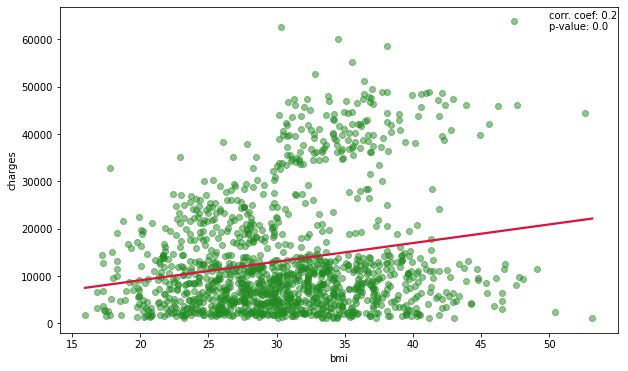

In [25]:
sns.regplot(x="bmi", y="charges", data=df, ci=None, color="forestgreen", scatter_kws={'alpha':.5}, line_kws={"color":"crimson"})
plt.annotate(bmi_charges_text, (50,62000))

Even though p value is almost zero, there is something strange with the fitted line, as if it splits the observations into two groups rather than "fitting" the points. From previous visualizations, it is obvious that smoking has a massive effect on charges, hence we might want to create different fitted lines for smokers and non-smokers.

In [26]:
smokers = df[df["smoker"]=="yes"]
non_smokers = df[df["smoker"]=="no"]

In [27]:
bmi_charges1 = stats.pearsonr(smokers["bmi"],smokers["charges"])
bmi_charges1_text = f"corr. coef: {round(bmi_charges1[0],2)} \np-value: {round(bmi_charges1[1],2)}"
bmi_charges2 = stats.pearsonr(non_smokers["bmi"],non_smokers["charges"])
bmi_charges2_text = f"corr. coef: {round(bmi_charges2[0],2)} \np-value: {round(bmi_charges2[1],2)}"

Text(49, 14000, 'corr. coef: 0.08 \np-value: 0.01')

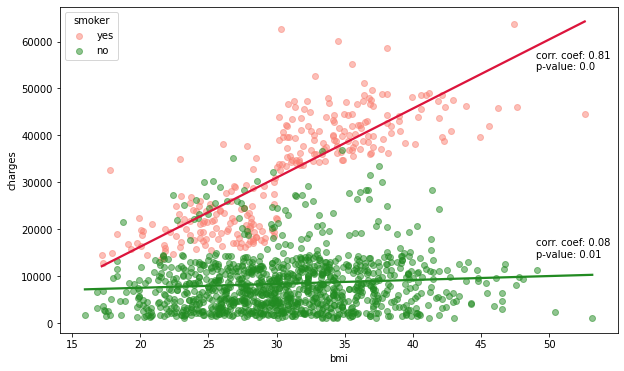

In [28]:
sns.regplot(x="bmi", y="charges", data=smokers, ci=None, color="salmon", scatter_kws={'alpha':.5}, line_kws={"color":"crimson"}, label="yes")
sns.regplot(x="bmi", y="charges", data=non_smokers, ci=None, color="forestgreen", scatter_kws={'alpha':.5}, line_kws={"color":"forestgreen"}, label="no")
plt.legend(title = "smoker", loc='upper left')
plt.annotate(bmi_charges1_text, (49,54000))
plt.annotate(bmi_charges2_text, (49,14000))

Voilà! On average, the effect of a unit increase in BMI for smokers has 10 times compared to non-smokers and there's a **very strong** linear relationship between BMI and charges for smokers.

##### Examine the relationship between "region", "smoker" and "bmi" using bar plot.

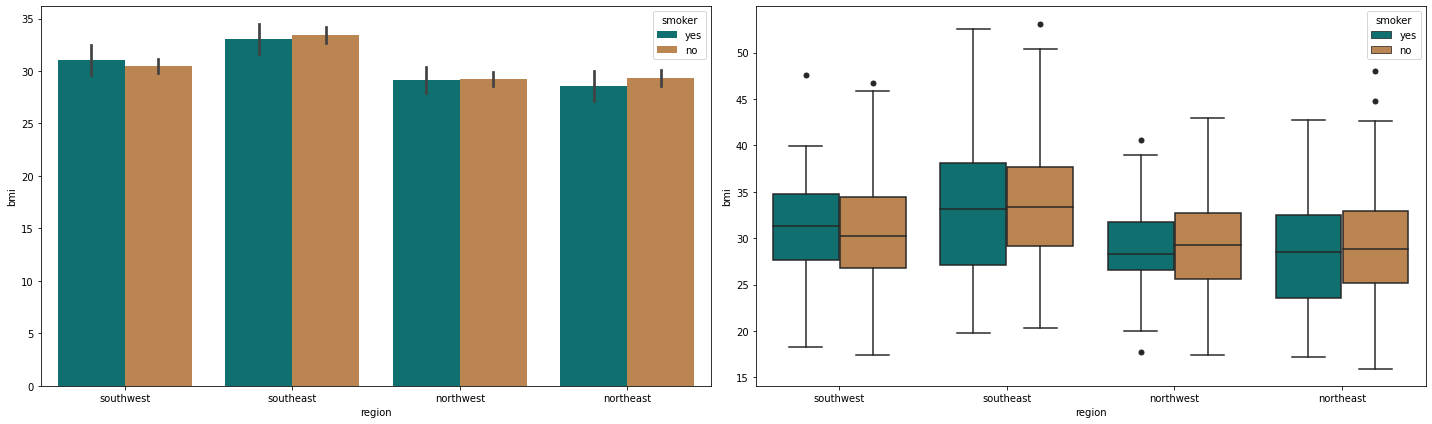

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
sns.barplot(data=df, x="region", y="bmi", hue="smoker", ax=axes[0], palette=["teal", "peru"])
sns.boxplot(data=df, x="region", y="bmi", hue="smoker", ax=axes[1], flierprops={"marker": "o"}, palette=["teal", "peru"])
plt.tight_layout()

Bar plots conceal distributions, that's why I added box plots. To be honest, I am not a fan of bar plot for series.

# Pre-processing

In [30]:
# let's create features (X) step by step
X = df.drop("charges", axis=1)
# converting sex and smoker columns into a dummy variables (sex -> 0:female, 1:male | smoker -> 0:no, 1:yes)
X["sex"] = pd.get_dummies(df["sex"], drop_first=True)
X["smoker"] = pd.get_dummies(df["smoker"], drop_first=True)
# creating one hot encoding for region variable ("northeast" is the reference level)
X = pd.concat([X, pd.get_dummies(df['region'], drop_first=True)], axis=1)
# then dropping region variable which became redundant
X.drop("region", axis=1, inplace=True)
# a glimpse of the features (X) data frame
X.head()

,age,sex,bmi,children,smoker,northwest,southeast,southwest
0,19,0,27.900,0,1,0,0,1
1,18,1,33.770,1,0,0,1,0
2,28,1,33.000,3,0,0,1,0
3,33,1,22.705,0,0,1,0,0
4,32,1,28.880,0,0,1,0,0


The target variable, charges, has a highly skewed distribution (and too many outliers) which may be problematic for regression analysis therefore it's better to transform it. Taking natural logarithm or using Box-Cox transformation might be handy. For monetary units, which are right-skewed in general, log transformation is a quick and widespread solution, so I will go on with that transformation.

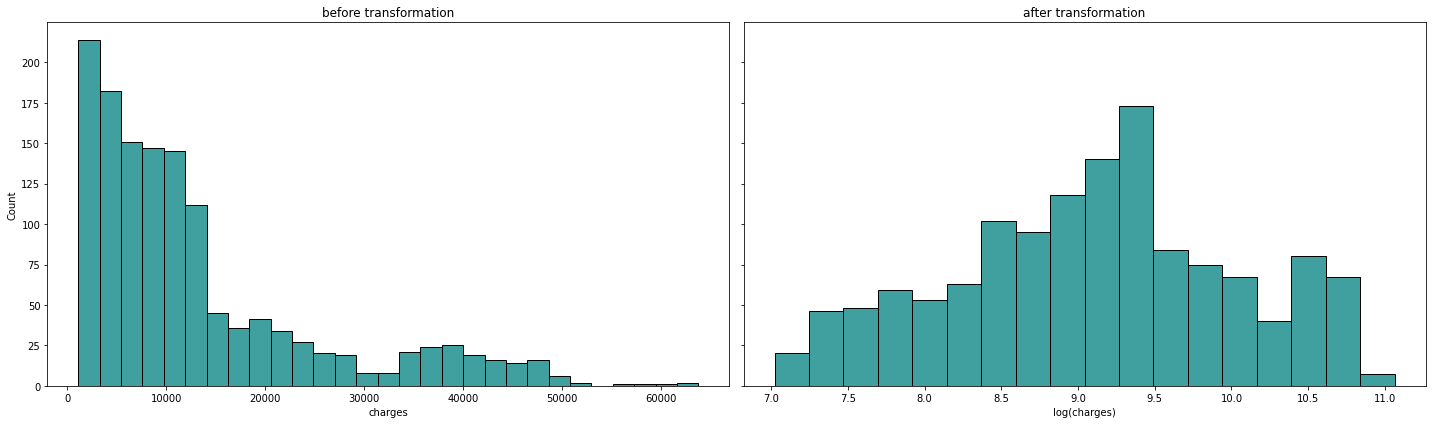

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)
sns.histplot(df["charges"], color="teal",ax=axes[0]).set(title="before transformation")
sns.histplot(np.log(df["charges"]), color="teal", ax=axes[1]).set(title="after transformation", xlabel="log(charges)")
plt.tight_layout()

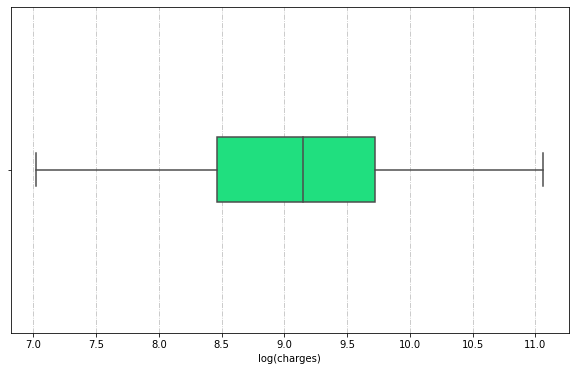

In [32]:
ax = sns.boxplot(x=np.log(df["charges"]), fliersize = 3, flierprops={"marker": "o"}, width = .2, color="springgreen")
ax.set_xlabel("log(charges)")
ax.set_axisbelow(True)
ax.grid(axis = "x", color = "gray", alpha = .5, linestyle = "dashdot")

By the help of natural logarithmic transformation we can get rid of the outliers.

In [33]:
# adding transformed value of charges
df["log_charges"] = np.log(df["charges"])
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


In [34]:
dat=pd.concat([X, df["log_charges"], df["charges"]], axis=1)

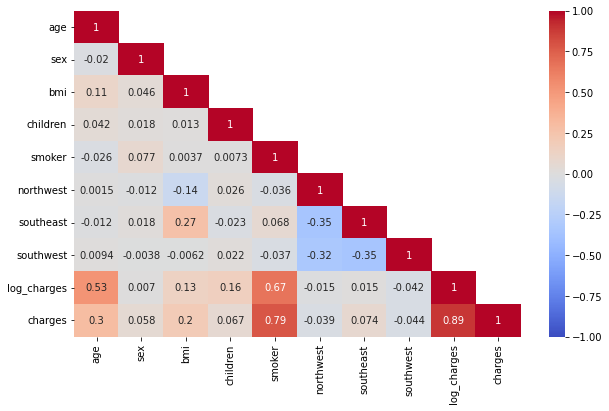

In [35]:
corr_df = dat.corr() # correlation matrix
lt_corr_df = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool))  # lower triangle matrix of corr_df
sns.heatmap(lt_corr_df, annot=True, cmap="coolwarm", vmin=-1)

In [36]:
y = df["charges"]
y_log = df["log_charges"] # I am also gonna predict log values

## Train-Test Split & Scaling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)
print(X_train.shape, X_test.shape)

(1069, 8) (268, 8)


In [38]:
# scaling features
sc = preprocessing.StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

# Modeling

Models used:
- Linear Regression
- Ridge Regression
- Lasso Regression
- ElasticNet
- Polynomial Regression
- Random Forest Regressor

## Linear Regression

In [39]:
lm=LinearRegression().fit(X_train_sc, y_train)

## Ridge Regression

In [40]:
ridge_params=[{"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
               "normalize":[True,False]}]

grid1 = GridSearchCV(Ridge(), ridge_params, cv=5, scoring="neg_root_mean_squared_error")
grid1.fit(X_train_sc, y_train)
grid1.best_params_

{'alpha': 10, 'normalize': False}

In [41]:
ridge_reg=Ridge(**grid1.best_params_).fit(X_train_sc, y_train)

## Lasso Regression

In [42]:
lasso_params=[{"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
grid2 = GridSearchCV(Lasso(), lasso_params, cv=5, scoring="neg_root_mean_squared_error")
grid2.fit(X_train_sc, y_train)
grid2.best_params_

{'alpha': 10}

In [43]:
lasso_reg=Lasso(**grid2.best_params_).fit(X_train_sc, y_train)

## ElasticNet

In [44]:
elastic_net_params=[{"alpha":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     "l1_ratio":np.linspace(0,1,11)}]

grid3 = GridSearchCV(ElasticNet(), elastic_net_params, cv=5, scoring="neg_root_mean_squared_error")
grid3.fit(X_train_sc, y_train)
grid3.best_params_

{'alpha': 0.1, 'l1_ratio': 0.9}

In [45]:
elastic_net=ElasticNet(**grid3.best_params_).fit(X_train_sc, y_train)

## Polynomial Regression

In [46]:
order=[1,2,3,4]
for n in order:
  print(f"For degree = {n}, average cross validation score (RMSE) is:")
  pr=preprocessing.PolynomialFeatures(degree=n)
  lr=LinearRegression()
  X_train_pr=pr.fit_transform(X_train_sc)
  print((cross_val_score(lr,X_train_pr, y_train, cv=5, scoring="neg_root_mean_squared_error")).mean()*-1)
  print(" ")

For degree = 1, average cross validation score (RMSE) is:
6113.877600907739
 
For degree = 2, average cross validation score (RMSE) is:
4911.270765264626
 
For degree = 3, average cross validation score (RMSE) is:
5090.051804421171
 
For degree = 4, average cross validation score (RMSE) is:
6610.192716132039
 


In [47]:
pr=preprocessing.PolynomialFeatures(degree=2).fit(X_train_sc)
X_train_pr=pr.transform(X_train_sc)
X_test_pr=pr.transform(X_test_sc) # for later use

In [48]:
poly_fit=LinearRegression().fit(X_train_pr, y_train)

## Random Forest Regressor

In [49]:
rf_params=[{"n_estimators":[10,100,200,500,1000],
            "max_depth":[None,2,4,8],
            "min_samples_split":[2,5,10]}]

grid4 = GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=5, scoring="neg_root_mean_squared_error")
grid4.fit(X_train_sc, y_train)
grid4.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [50]:
rf_reg=RandomForestRegressor(random_state=0,**grid4.best_params_).fit(X_train_sc, y_train)

# Model Predictions & Evaluation

In [51]:
lm_pred=lm.predict(X_test_sc)
ridge_pred=ridge_reg.predict(X_test_sc)
lasso_pred=lasso_reg.predict(X_test_sc)
elastic_net_pred=elastic_net.predict(X_test_sc)
poly_pred=poly_fit.predict(X_test_pr)
rf_pred=rf_reg.predict(X_test_sc)

In [52]:
rmse_res=[["Lin. Reg.", mean_squared_error(y_test,lm_pred, squared=False)],
          ["Ridge Reg.", mean_squared_error(y_test,ridge_pred, squared=False)],
          ["Lasso Reg.", mean_squared_error(y_test,lasso_pred, squared=False)],
          ["ElasticNet", mean_squared_error(y_test,elastic_net_pred, squared=False)],
          ["Polynomial", mean_squared_error(y_test,poly_pred, squared=False)],
          ["Random Forest", mean_squared_error(y_test,rf_pred, squared=False)]
]
rmse_df = pd.DataFrame(rmse_res, columns=["Regressors","RMSE"]).set_index("Regressors").sort_values(by="RMSE")
rmse_df

,RMSE
Regressors,
Random Forest,4272.474770
Polynomial,4649.356694
Lin. Reg.,5956.342894
Lasso Reg.,5962.632856
Ridge Reg.,5985.729537
ElasticNet,5987.851948


Text(0.5, 1.0, 'RMSE of Regressors')

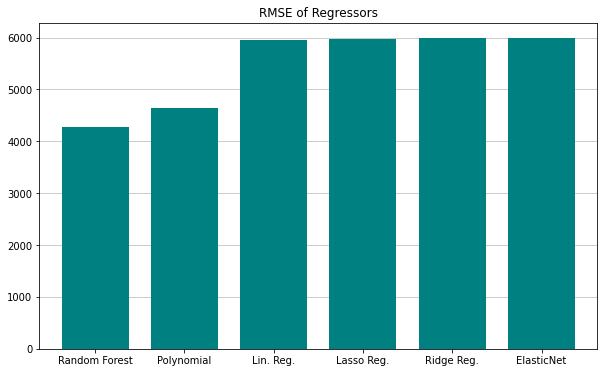

In [53]:
ax = rmse_df.plot(kind="bar", rot=0, legend = None, color = "teal", width = .75)
ax.set_xlabel("")
ax.set_axisbelow(True)
ax.grid(axis = "y", color = "gray", alpha = .5)
ax.set_title("RMSE of Regressors")

Random Forest Regressor performs better than the others (but don't forget that results may vary according to parameter sets in grid search). Now's the time to compare the actual and predicted values.

In [54]:
act_vs_pred=y_test.to_frame()
act_vs_pred["predicted"]=rf_pred
act_vs_pred.head(10)

,charges,predicted
900,8688.85885,11061.254821
1064,5708.86700,7266.737651
1256,11436.73815,11824.396686
298,38746.35510,42553.898615
237,4463.20510,6606.411771
481,9304.70190,10960.661558
240,38511.62830,37489.631015
277,2150.46900,3155.440348
415,7345.72660,8385.062202
707,10264.44210,11372.271747


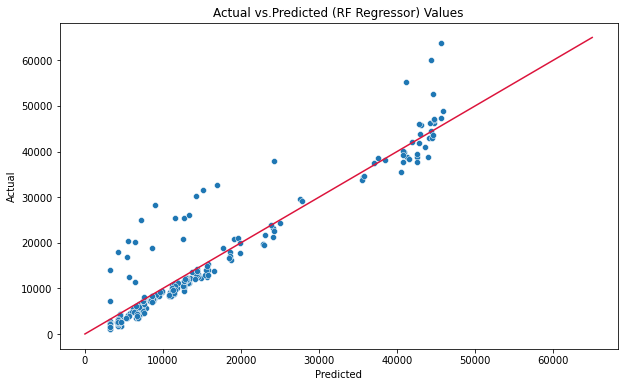

In [55]:
sns.scatterplot(x=rf_pred, y=y_test).set(title="Actual vs.Predicted (RF Regressor) Values", xlabel="Predicted", ylabel="Actual")
plt.plot([0,65000], [0,65000], color="crimson")

# How About Estimating log(charges)?

In [56]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, random_state = 42, test_size=0.2)
print(X_train.shape, X_test.shape)

(1069, 8) (268, 8)


## Modeling

In [57]:
# linear model
lm_log=LinearRegression().fit(X_train_sc, y_train_log)

In [58]:
# polynomial regression
order=[1,2,3,4]
for n in order:
  print(f"For degree = {n}, average cross validation score (RMSE) is:")
  pr=preprocessing.PolynomialFeatures(degree=n)
  lr=LinearRegression()
  X_train_pr=pr.fit_transform(X_train_sc)
  print((cross_val_score(lr,X_train_pr, y_train_log, cv=5, scoring="neg_root_mean_squared_error")).mean()*-1)
  print(" ")

For degree = 1, average cross validation score (RMSE) is:
0.455438363738645
 
For degree = 2, average cross validation score (RMSE) is:
0.38470534780462484
 
For degree = 3, average cross validation score (RMSE) is:
0.39706159173039834
 
For degree = 4, average cross validation score (RMSE) is:
0.48269361191781374
 


In [59]:
pr=preprocessing.PolynomialFeatures(degree=2).fit(X_train_sc)
X_train_pr=pr.transform(X_train_sc)
X_test_pr=pr.transform(X_test_sc) # for later use
poly_log=LinearRegression().fit(X_train_pr, y_train_log)

In [60]:
# random forest regressor
rf_params=[{"n_estimators":[10,100,200,500,1000],
            "max_depth":[None,2,4,8],
            "min_samples_split":[2,5,10]}]

grid_log = GridSearchCV(RandomForestRegressor(random_state=0), rf_params, cv=5, scoring="neg_root_mean_squared_error")
grid_log.fit(X_train_sc, y_train_log)
grid_log.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200}

In [61]:
rf_log=RandomForestRegressor(random_state=0,**grid_log.best_params_).fit(X_train_sc, y_train_log)

**Important Note:** Natural logarithm of charges, log(charges), is estimated so we need to transform back again in order to compare previous models.

In [62]:
lm_log_pred=lm_log.predict(X_test_sc)
poly_log_pred=poly_log.predict(X_test_pr)
rf_log_pred=rf_log.predict(X_test_sc)

In [63]:
rmse_res_log=[["Lin. Reg.", mean_squared_error(y_test_log,lm_log_pred, squared=False)],
              ["Polynomial", mean_squared_error(y_test_log,poly_log_pred, squared=False)],
              ["Random Forest", mean_squared_error(y_test_log,rf_log_pred, squared=False)]
]
rmse_log_df = pd.DataFrame(rmse_res_log, columns=["Regressors","RMSE"]).set_index("Regressors").sort_values(by="RMSE")
rmse_log_df

,RMSE
Regressors,
Polynomial,0.325827
Random Forest,0.340699
Lin. Reg.,0.397854


In [64]:
mat=y_test.to_frame()
mat["log actual"]=y_test_log
mat["log predicted"]=poly_log_pred
mat["predicted"]=np.e**mat["log predicted"]
mat.head(10)

,charges,log actual,log predicted,predicted
900,8688.85885,9.069797,8.979492,7938.599772
1064,5708.86700,8.649776,8.730957,6191.650880
1256,11436.73815,9.344586,9.477539,13062.999700
298,38746.35510,10.564792,10.618652,40890.471480
237,4463.20510,8.403622,8.510742,4967.848796
481,9304.70190,9.138275,9.234375,10243.257877
240,38511.62830,10.558716,10.837891,50913.868192
277,2150.46900,7.673441,7.823242,2497.991249
415,7345.72660,8.901874,8.984375,7977.457255
707,10264.44210,9.236441,9.400391,12093.103676


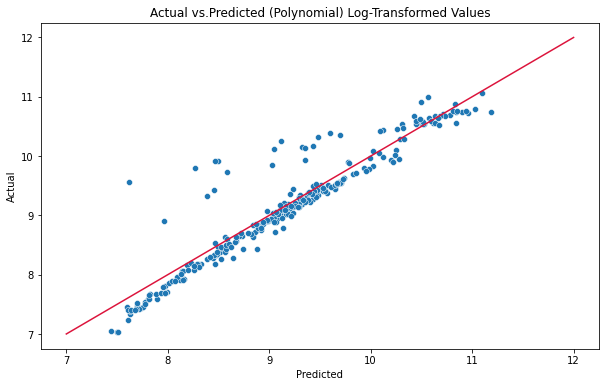

In [65]:
sns.scatterplot(x=poly_log_pred, y=y_test_log).set(title="Actual vs.Predicted (Polynomial) Log-Transformed Values", xlabel="Predicted", ylabel="Actual")
plt.plot([7,12], [7,12], color="crimson")

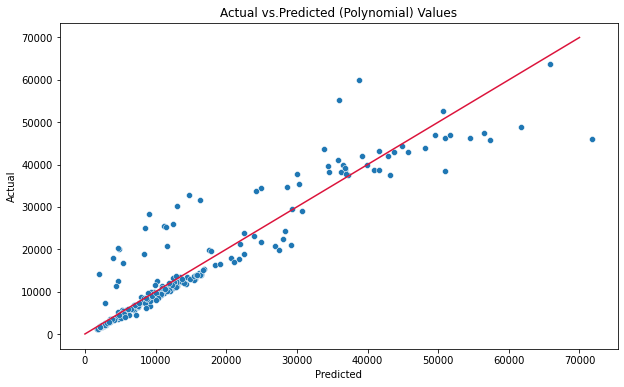

In [66]:
sns.scatterplot(x=mat["predicted"], y=y_test).set(title="Actual vs.Predicted (Polynomial) Values", xlabel="Predicted", ylabel="Actual")
plt.plot([0,70000], [0,70000], color="crimson")

In [67]:
round(mean_squared_error(mat["charges"],mat["predicted"],squared=False),2)

4952.74

So transforming the target variable won't improve the results and *Random Forest regressor* predicting non-transformed values of charges is still best model so far.